# Options Chain Predictions

In [1]:
# !pip install tensorflow
# !pip install keras
# !pip install yfinance

In [2]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
import datetime
from math import *
from statistics import *
# import numpy as np
from scipy.stats import norm

In [3]:
'''
Need table for:
    Stock Price
    Strike Price
    Maturity
    Volatility
    Risk-Free
    Call Price
'''


'\nNeed table for:\n    Stock Price\n    Strike Price\n    Maturity\n    Volatility\n    Risk-Free\n    Call Price\n'

In [4]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls)
#         .append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date
    # Add 1 day to get the correct expiration date
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + datetime.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days
#     / 365
    
#     # Boolean column if the option is a CALL
#     options['CALL'] = options['contractSymbol'].str[4:].apply(
#         lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['midpt'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['volume','openInterest','inTheMoney','contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate'])

    return options

In [5]:
tckstock='MSFT'
opt = options_chain(tckstock)

In [6]:
sttck = yf.Ticker(tckstock)
# sttck.info
# 37,734.562 current price
# tckstock.info
stck_pr = 219.62
r = 0.09

In [7]:
len(opt)

745

In [8]:
opt.to_csv('options_chain.csv')

In [9]:
opt.head()

,contractSymbol,strike,lastPrice,bid,ask,impliedVolatility,expirationDate,dte,midpt
0,MSFT210115C00050000,50.0,168.05,168.05,168.25,4.484379,2021-01-16,4,168.150
1,MSFT210115C00055000,55.0,168.35,163.05,163.25,4.203130,2021-01-16,4,163.150
2,MSFT210115C00060000,60.0,157.18,158.05,158.25,3.937500,2021-01-16,4,158.150
3,MSFT210115C00065000,65.0,160.44,152.50,153.75,5.101566,2021-01-16,4,153.125
4,MSFT210115C00070000,70.0,148.13,147.70,148.55,4.484379,2021-01-16,4,148.125


## Black Scholes Est.

In [10]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

In [11]:
iv = len(opt)
iv_list=[1]*iv
opt['iv_list']=iv_list

In [12]:
samp = black_scholes(opt['lastPrice'][0],55,opt['dte'][0],r,opt['impliedVolatility'][0])
print(samp)

168.03527193146442


In [13]:
# samp
# create a list for the bS and add it to df
bS=[]
for x in range(len(opt)):
    bS.append(black_scholes(opt['lastPrice'][x],opt['strike'][x],opt['dte'][x],r,opt['impliedVolatility'][x]))

In [14]:
# bS
opt['bS']=bS

In [15]:
opt.head()

,contractSymbol,strike,lastPrice,bid,ask,impliedVolatility,expirationDate,dte,midpt,iv_list,bS
0,MSFT210115C00050000,50.0,168.05,168.05,168.25,4.484379,2021-01-16,4,168.150,1,168.039971
1,MSFT210115C00055000,55.0,168.35,163.05,163.25,4.203130,2021-01-16,4,163.150,1,168.315987
2,MSFT210115C00060000,60.0,157.18,158.05,158.25,3.937500,2021-01-16,4,158.150,1,157.064823
3,MSFT210115C00065000,65.0,160.44,152.50,153.75,5.101566,2021-01-16,4,153.125,1,160.435470
4,MSFT210115C00070000,70.0,148.13,147.70,148.55,4.484379,2021-01-16,4,148.125,1,148.077269


In [16]:
# get percentage change
error_=[]
for x in range(len(opt)):
    try:
        error_.append(((opt['bS'][x]-opt['lastPrice'][x])/opt['lastPrice'][x]))
    except:
#         error_.append('nan')
        continue
opt['error'] = error_

In [17]:
opt.head()

,contractSymbol,strike,lastPrice,bid,ask,impliedVolatility,expirationDate,dte,midpt,iv_list,bS,error
0,MSFT210115C00050000,50.0,168.05,168.05,168.25,4.484379,2021-01-16,4,168.150,1,168.039971,-0.000060
1,MSFT210115C00055000,55.0,168.35,163.05,163.25,4.203130,2021-01-16,4,163.150,1,168.315987,-0.000202
2,MSFT210115C00060000,60.0,157.18,158.05,158.25,3.937500,2021-01-16,4,158.150,1,157.064823,-0.000733
3,MSFT210115C00065000,65.0,160.44,152.50,153.75,5.101566,2021-01-16,4,153.125,1,160.435470,-0.000028
4,MSFT210115C00070000,70.0,148.13,147.70,148.55,4.484379,2021-01-16,4,148.125,1,148.077269,-0.000356


In [18]:
df_plt=opt[['contractSymbol','error']].copy()

In [19]:
df_plt.to_csv('df_plt.csv')

In [20]:
df_plt.set_index('contractSymbol',inplace=True)

In [21]:
# edit df to remove tradeless price days
# 577-578
e=745-578
df_plt = df_plt.iloc[:232]

In [22]:
df_plt.tail()

,error
contractSymbol,
MSFT210219C00305000,-0.999991
MSFT210219C00310000,-0.999987
MSFT210219C00315000,-0.999995
MSFT210219C00320000,-1.000000
MSFT210219C00325000,-1.000000


In [23]:
df_plt.to_csv('df_plt_again.csv')

<AxesSubplot:xlabel='contractSymbol', ylabel='error'>

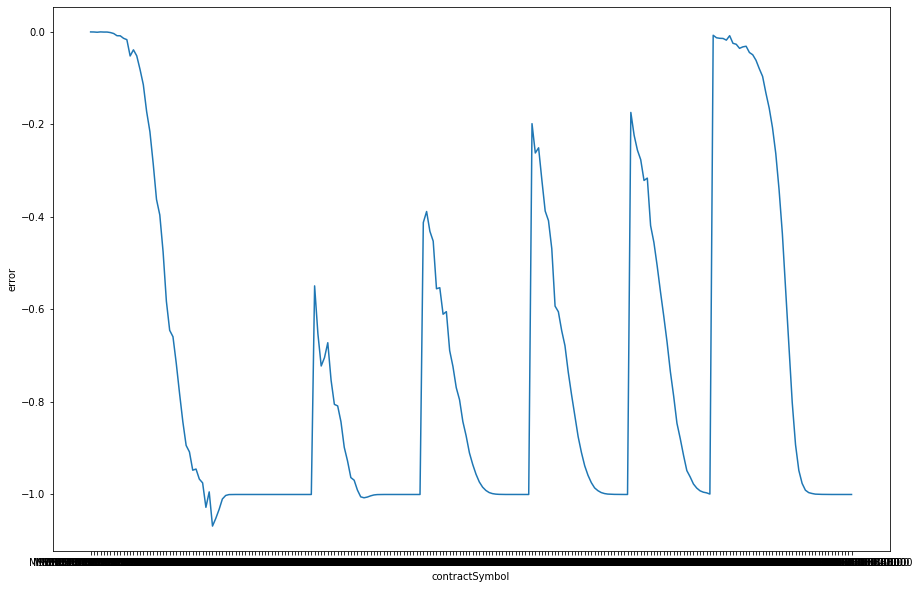

In [24]:
# plottin
# df_plt.plot(figsize=(10,10))
plt.figure(figsize=(15,10))
#plt.xticks(rotation='vertical')
sns.lineplot(data=df_plt, x="contractSymbol", y="error")

## ANN

In [25]:
# fresh libs for the ann
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

In [26]:
n=len(opt)
r_list = [0.09] * n
# r_list
opt['r_list']=r_list


In [27]:
# set up fresh df with the same cols as Culkin and Das
'''
    Stock Price
    Strike Price
    Maturity
    Volatility
    Risk-Free
    Call Price
'''
anndf=opt[['lastPrice','strike','dte','impliedVolatility','r_list','bS']].copy()
anndf = anndf.rename(columns={'lastPrice': 'StockPrice', 'strike': 'StrikePrice', 'dte':'Maturity', 'impliedVolatility':'Volatility', 'r_list':'RiskFree','bS':'CallPrice'})

In [28]:
anndf.head()

,StockPrice,StrikePrice,Maturity,Volatility,RiskFree,CallPrice
0,168.05,50.0,4,4.484379,0.09,168.039971
1,168.35,55.0,4,4.203130,0.09,168.315987
2,157.18,60.0,4,3.937500,0.09,157.064823
3,160.44,65.0,4,5.101566,0.09,160.435470
4,148.13,70.0,4,4.484379,0.09,148.077269


In [29]:
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
anndf["StockPrice"] = anndf["StockPrice"]/anndf["StrikePrice"]
anndf["CallPrice"] = anndf["CallPrice"]/anndf["StrikePrice"]

In [30]:
anndf.head()

,StockPrice,StrikePrice,Maturity,Volatility,RiskFree,CallPrice
0,3.361000,50.0,4,4.484379,0.09,3.360799
1,3.060909,55.0,4,4.203130,0.09,3.060291
2,2.619667,60.0,4,3.937500,0.09,2.617747
3,2.468308,65.0,4,5.101566,0.09,2.468238
4,2.116143,70.0,4,4.484379,0.09,2.115390


Before feeding the data into TensorFlow, we set it up appropriately into training (80%) and testing data (20%) sets.

In [31]:
len(anndf)

745

In [37]:
anndf=anndf. dropna()

In [38]:
len(anndf)

745

In [32]:
n = len(anndf)
n_train =  (int)(0.8 * n)
train = anndf[0:n_train]
X_train = train[['StockPrice', 'Maturity', 'Volatility', 'RiskFree']].values
y_train = train['CallPrice'].values
test = anndf[n_train+1:n]
X_test = test[['StockPrice', 'Maturity', 'Volatility', 'RiskFree']].values
y_test = test['CallPrice'].values

Because the model aims to produce a positive continuous value for the option price, we cannot use the standard squashing functions that are used in TensorFlow, such as the sigmoid function. These functions emit values in the range (0,1) and are not suitable for the range (0,∞), which is what we require. Therefore, we need to build our own output node functions, which is shown as a new python function in the following code block. The exponential function is used because it returns positive-only values

In [33]:
def custom_activation(x):
    return backend.exp(x)

The  details  of  the  deep  learning  net  are  as  follows.   
The  size  of  the  input  is  5 parameters.   
These  are  passed  through  4  hidden  layers  of  120  neurons  each.   
The neurons at each layer are chosen based on different “activation” functions that are respectively  the  following:  
- LeakyReLU,  
- ELU,  
- ReLU,  
- ELU.  

The  final  output  layer comprises a single output neuron which we set to be the standard exponential function exp() because we need the output of the neural net to be non-negative with certainty, as option prices cannot take negative values.
We  chose  some  simple  “hyper-parameters”  for  the  deep  learning  net.   
At  each hidden layer we used a dropout rate of 25% so as to ameliorate overfitting.  
The loss function  used  for  optimization  is  mean-squared  error  (MSE)  and  we  implemented a batch size of 64,  with 10 epochs.  
The entire exercise results in fitting a total of 31,101  coefficients  (weights)  for  the  deep  learning  model. 

In [39]:
nodes = 100
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation(custom_activation))

model.compile(loss='mse',optimizer='rmsprop')

We can then run the fitting method to calibrate the model by using loss function MSE. We used 10 epochs.

In [43]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
9/9 - 0s - loss: 0.2533 - val_loss: 0.3374
Epoch 2/10
9/9 - 0s - loss: 0.2481 - val_loss: 0.3374
Epoch 3/10
9/9 - 0s - loss: 0.2845 - val_loss: 0.3374
Epoch 4/10
9/9 - 0s - loss: 0.3214 - val_loss: 0.3374
Epoch 5/10
9/9 - 0s - loss: 0.2481 - val_loss: 0.3374
Epoch 6/10
9/9 - 0s - loss: 0.2620 - val_loss: 0.3374
Epoch 7/10
9/9 - 0s - loss: 0.2615 - val_loss: 0.3374
Epoch 8/10
9/9 - 0s - loss: 0.2430 - val_loss: 0.3374
Epoch 9/10
9/9 - 0s - loss: 0.2629 - val_loss: 0.3374
Epoch 10/10
9/9 - 0s - loss: 0.2939 - val_loss: 0.3374


We also define a special function to check the accuracy of the model. It generates several common statistics that we may find useful.

In [46]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    '''
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=1,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20)
    plt.ylabel('Predicted Price',fontsize=20) 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    '''
    return stats

In [48]:
y_train_hat = model.predict(X_train)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = np.squeeze(y_train_hat)
# CheckAccuracy(y_train, y_train_hat)

https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing
https://srdas.github.io/Papers/BlackScholesNN.pdf

## LSTM

https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3

https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944